In [ ]:
map0 = {'bacno':'歸戶帳號','txkey':'交易序號','locdt':'授權日期','loctm':'授權時間','cano':'交易卡號',
         'contp':'交易類別','etymd':'交易型態','mchno':'特店代號','acqic':'收單行代碼','mcc':'MCC_CODE',
         'conam':'交易金額-台幣(經過轉換)','ecfg':'網路交易註記','insfg':'分期交易註記','iterm':'分期期數',
         'stocn':'消費地國別','scity':'消費城市','stscd':'狀態碼','ovrlt':'超額註記碼','flbmk':'Fallback註記',
         'hcefg':'支付型態','csmcu':'消費地幣別','flg_3dsmk':'3DS交易註記','fraud_ind':'盜刷註記'}
#盜刷時間:出現在凌晨時段 (loctm)
#線上/實體店:盜刷70%都是在網上(ecfg)
#盜刷小額交易的部分偏高(conam)
#狀態碼2在盜刷中佔比比正常交易高(stscd)
#做x,y相關係數分析抓出幾個特徵來訓練


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score , average_precision_score 
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve ,auc , log_loss ,  classification_report
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)


In [201]:
train_x_og = pd.read_csv("train_x.csv")
train_y_og = pd.read_csv("train_y.csv")
#test_x_og = pd.read_csv('test_x.csv')


print(train_x_og.shape,train_y_og.shape)

(1521787, 139) (1521787, 2)


In [202]:
#test data是real distribution，非常imbalance

from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(train_x_og,train_y_og, test_size=0.25, random_state=42)##shuffle=False

test_x = test_x.set_index('txkey')
test_y = test_y.set_index('txkey')

##downsampling
# index_1 = train_y[train_y.fraud_ind==1].index
# index_0 = train_y[train_y.fraud_ind==0].sample(len(index_1), random_state=111).index
# index = index_0.to_list()+index_1.to_list()
# train_x = train_x.loc[index]#.sort_index()
# train_y = train_y.loc[index]#.sort_index()

train_x = train_x.set_index('txkey')
train_y = train_y.set_index('txkey')



print(train_x.shape,train_y.shape,test_x.shape,test_y.shape)


(1141340, 138) (1141340, 1) (380447, 138) (380447, 1)


In [203]:
print(train_x.keys().tolist())
train_x

['contp', 'csmcu', 'flbmk', 'flg_3dsmk', 'insfg', 'iterm', 'locdt', 'mcc', 'mchno', 'ovrlt', 'acqic', 'scity', 'loctm_k_3', 'loctm_k_0', 'loctm_k_1', 'loctm_k_2', 'etymd_k_3', 'etymd_k_0', 'etymd_k_4', 'etymd_k_2', 'etymd_k_1', 'hcefg_k_0', 'hcefg_k_1', 'stocn_102', 'stocn_44', 'stocn_38', 'stocn_98', 'stocn_32', 'stocn_20', 'stocn_46', 'stocn_16', 'stocn_104', 'stocn_52', 'stocn_93', 'stocn_25', 'stocn_75', 'stocn_5', 'stocn_27', 'stocn_10', 'stocn_36', 'stocn_92', 'stocn_85', 'stocn_42', 'stocn_17', 'stocn_26', 'stocn_89', 'stocn_6', 'stocn_48', 'stocn_61', 'stocn_68', 'stocn_81', 'stocn_62', 'stocn_72', 'stocn_2', 'stocn_73', 'stocn_55', 'stocn_78', 'stocn_95', 'stocn_106', 'stocn_41', 'stocn_1', 'stocn_77', 'stocn_56', 'stocn_28', 'stocn_83', 'stocn_18', 'stocn_71', 'stocn_50', 'stocn_94', 'stocn_14', 'stocn_13', 'stocn_80', 'stocn_45', 'stocn_40', 'stocn_49', 'stocn_107', 'stocn_34', 'stocn_76', 'stocn_90', 'stocn_37', 'stocn_74', 'stocn_0', 'stocn_9', 'stocn_101', 'stocn_84', 'st

,contp,csmcu,flbmk,flg_3dsmk,insfg,iterm,locdt,mcc,mchno,ovrlt,acqic,scity,loctm_k_3,loctm_k_0,loctm_k_1,loctm_k_2,etymd_k_3,etymd_k_0,etymd_k_4,etymd_k_2,etymd_k_1,hcefg_k_0,hcefg_k_1,stocn_102,stocn_44,stocn_38,stocn_98,stocn_32,stocn_20,stocn_46,stocn_16,stocn_104,stocn_52,stocn_93,stocn_25,stocn_75,stocn_5,stocn_27,stocn_10,stocn_36,stocn_92,stocn_85,stocn_42,stocn_17,stocn_26,stocn_89,stocn_6,stocn_48,stocn_61,stocn_68,...,stocn_60,stocn_70,stocn_31,stocn_47,stocn_88,stocn_30,stocn_54,stocn_67,stocn_7,stocn_96,stocn_35,stocn_15,stocn_65,stocn_4,stocn_22,stocn_19,stocn_39,stocn_63,stocn_57,stocn_99,stocn_51,stocn_79,stocn_86,stocn_11,stocn_53,stocn_91,stocn_43,stocn_8,stocn_59,stocn_64,stocn_97,stocn_3,stocn_82,stocn_12,stocn_29,stocn_24,stocn_100,stocn_33,ecfg_0,ecfg_1,stscd_0,stscd_2,stscd_3,stscd_1,stscd_4,conam_k_0,conam_k_4,conam_k_3,conam_k_2,conam_k_1
txkey,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1801324,5,62,0,0,0,0,64,-0.521784,-0.141336,0,-0.022941,0.536031,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1772620,5,62,0,0,0,0,17,1.148890,-0.492558,0,0.472498,-0.587383,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1798653,5,62,0,0,0,0,60,0.115878,-1.688656,0,0.382841,-0.743258,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1663542,5,62,0,0,0,0,72,-0.598303,1.385128,0,-0.019621,0.536031,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1505624,5,62,0,0,1,1,48,-0.649316,-0.704304,0,0.472498,0.537544,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494486,5,0,0,0,0,0,15,2.028863,0.112772,0,0.582079,-2.398364,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1027521,5,62,0,0,0,0,83,1.480474,-0.159922,0,0.472498,-0.743258,0.0,1.0,0.0,0.0,0.0,1.0,0.0,

In [57]:
# ##load data from data_preprocessing_v1
# train_x = pd.read_csv('./datas/train_x.csv').set_index('txkey')
# val_x = pd.read_csv('./datas/val_x.csv').set_index('txkey')
# test_x = pd.read_csv('./datas/test_x.csv').set_index('txkey')
# train_y =pd.read_csv('./datas/train_y.csv').set_index('txkey')
# val_y = pd.read_csv('./datas/val_y.csv').set_index('txkey')
# test_y = pd.read_csv('./datas/test_y.csv').set_index('txkey')

In [139]:
# print(train_x.shape, val_x.shape, test_x.shape, train_y.shape, val_y.shape, test_y.shape)

# test_y['fraud_ind'].value_counts()
# display(train_x.head(100))
# display(val_x.head(100))
# #display(test_x.head(100))

# print(train_x.keys())
# train_x = pd.read_csv('./data/X_sample.csv').drop(columns=['cano','bacno']).set_index('txkey')
# test_x = pd.read_csv('./data/X_test.csv').drop(columns=['cano','bacno']).set_index('txkey')
# train_y =pd.read_csv('./data/y_sample.csv').set_index('txkey')
# test_y = pd.read_csv('./data/y_test.csv').set_index('txkey')

# LGBM

In [204]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y = train_test_split(train_x,train_y, test_size=0.25, random_state=42)##shuffle=False
print(train_x.shape,val_x.shape,train_y.shape,val_y.shape)

# create dataset for lightgbm
lgb_train = lgb.Dataset(train_x, train_y)
lgb_eval = lgb.Dataset(val_x, val_y, reference=lgb_train)

(856005, 138) (285335, 138) (856005, 1) (285335, 1)


In [205]:
# specify your configurations as a dict
params={}
params['learning_rate']=0.03
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='binary' #Binary target feature
params['metric']='binary_logloss' #metric for binary classification
params['max_depth']=10

print('Starting training...')

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=200,
                valid_sets=lgb_eval,
                early_stopping_rounds=20)

Starting training...
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 11527, number of negative: 844478
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1117
[LightGBM] [Info] Number of data points in the train set: 856005, number of used features: 94
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013466 -> initscore=-4.294027
[LightGBM] [Info] Start training from score -4.294027
[1]	valid_0's binary_loglo

[174]	valid_0's binary_logloss: 0.030795
[175]	valid_0's binary_logloss: 0.0307795
[176]	valid_0's binary_logloss: 0.0307734
[177]	valid_0's binary_logloss: 0.0307639
[178]	valid_0's binary_logloss: 0.0307563
[179]	valid_0's binary_logloss: 0.0307418
[180]	valid_0's binary_logloss: 0.0307227
[181]	valid_0's binary_logloss: 0.0307123
[182]	valid_0's binary_logloss: 0.0307012
[183]	valid_0's binary_logloss: 0.0306875
[184]	valid_0's binary_logloss: 0.0306731
[185]	valid_0's binary_logloss: 0.030662
[186]	valid_0's binary_logloss: 0.0306496
[187]	valid_0's binary_logloss: 0.0306349
[188]	valid_0's binary_logloss: 0.0306308
[189]	valid_0's binary_logloss: 0.030613
[190]	valid_0's binary_logloss: 0.0306052
[191]	valid_0's binary_logloss: 0.0305983
[192]	valid_0's binary_logloss: 0.0305854
[193]	valid_0's binary_logloss: 0.0305708
[194]	valid_0's binary_logloss: 0.0305632
[195]	valid_0's binary_logloss: 0.0305522
[196]	valid_0's binary_logloss: 0.0305415
[197]	valid_0's binary_logloss: 0.030

Starting predicting...
auc: 0.9767817381988596
confusion matrix:
[[281543      0]
 [  3787      5]]
accuracy:  0.9867278812623758
precision: 1.0
recall: 0.0013185654008438818
f1_score: 0.002633658151171978


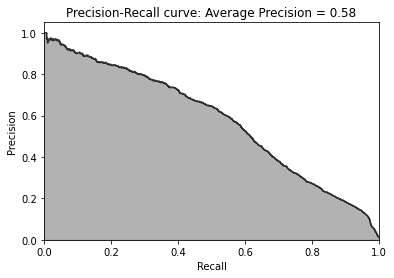

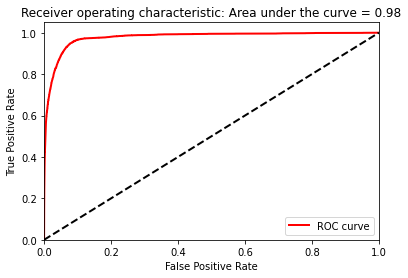

In [206]:
print('Starting predicting...')
# predict
pred_y = gbm.predict(val_x, num_iteration=gbm.best_iteration)
# eval
th = 0.9
print('auc:', roc_auc_score(val_y, pred_y))
print('confusion matrix:')
print(confusion_matrix(val_y, (pred_y > th).astype(int)))
print('accuracy: ', accuracy_score(val_y, (pred_y > th)))
print('precision:', precision_score(val_y, (pred_y > th)))
print('recall:', recall_score(val_y, (pred_y > th)))
print('f1_score:', f1_score(val_y, (pred_y > th)))

precision, recall, thresholds = precision_recall_curve(val_y,pred_y)
average_precision = average_precision_score(val_y,pred_y)

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

fpr, tpr, thresholds = roc_curve(val_y,pred_y)
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

Starting predicting...
auc: 0.9764244662671
confusion matrix:
[[373290   2121]
 [  2186   2850]]
accuracy:  0.9886791064195538
precision: 0.5733252866626434
recall: 0.5659253375694996
f1_score: 0.5696012791046268


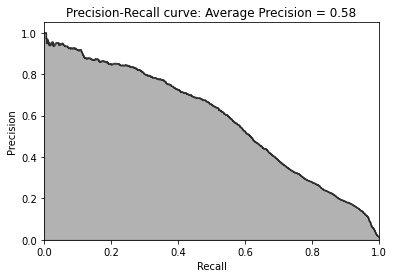

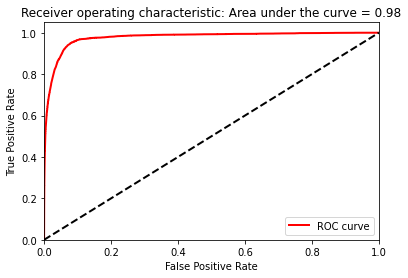

In [207]:
print('Starting predicting...')
# predict
pred_y = gbm.predict(test_x, num_iteration=gbm.best_iteration)
# eval
th = 0.25
print('auc:', roc_auc_score(test_y, pred_y))
print('confusion matrix:')
print(confusion_matrix(test_y, (pred_y > th).astype(int)))
print('accuracy: ', accuracy_score(test_y, (pred_y > th)))
print('precision:', precision_score(test_y, (pred_y > th)))
print('recall:', recall_score(test_y, (pred_y > th)))
print('f1_score:', f1_score(test_y, (pred_y > th)))

precision, recall, thresholds = precision_recall_curve(test_y,pred_y)
average_precision = average_precision_score(test_y,pred_y)

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

fpr, tpr, thresholds = roc_curve(test_y,pred_y)
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

# Random forest

In [208]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
forest = RandomForestClassifier(criterion='entropy',n_estimators = 100,random_state=3,n_jobs=2)
forest.fit(train_x, np.ravel(train_y))



RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
                       oob_score=False, random_state=3, verbose=0,
                       warm_start=False)

Starting predicting...
auc: 0.7696306111408965
confusion matrix:
[[374421    990]
 [  2307   2729]]
accuracy:  0.9913338783063081
precision: 0.7337994084431299
recall: 0.5418983320095314
f1_score: 0.6234151913192462


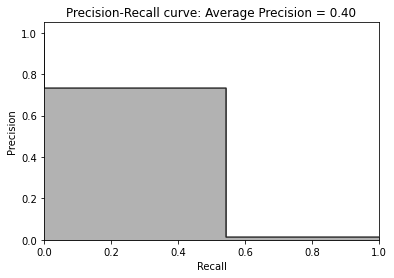

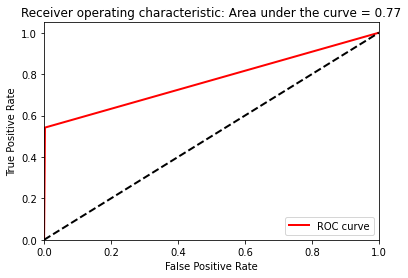

In [209]:
print('Starting predicting...')
pred_y = forest.predict(test_x)
# eval
th = 0.3
print('auc:', roc_auc_score(test_y, pred_y))
print('confusion matrix:')
print(confusion_matrix(test_y, (pred_y > 0.5).astype(int)))
print('accuracy: ', accuracy_score(test_y, (pred_y > th)))
print('precision:', precision_score(test_y, (pred_y > th)))
print('recall:', recall_score(test_y, (pred_y > th)))
print('f1_score:', f1_score(test_y, (pred_y > th)))

precision, recall, thresholds = precision_recall_curve(test_y,pred_y)
average_precision = average_precision_score(test_y,pred_y)

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

fpr, tpr, thresholds = roc_curve(test_y,pred_y)
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

# KNN

In [123]:
#col = ['acqic', 'bacno', 'cano', 'conam', 'loctm', 'mcc', 'mchno', 'scity','contp_0', 'contp_1']
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
print('Starting training...')

clf=KNeighborsClassifier(n_neighbors=5,p=1,weights='distance',algorithm='brute')
clf.fit(train_x, np.ravel(train_y))

Starting training...


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=1,
                     weights='distance')

Starting predicting...
auc: 0.9305188207227205
confusion matrix:
[[3524  349]
 [ 185 3602]]
precision: 0.9116679321690712
recall: 0.9511486664906258
f1_score: 0.9309899198759369


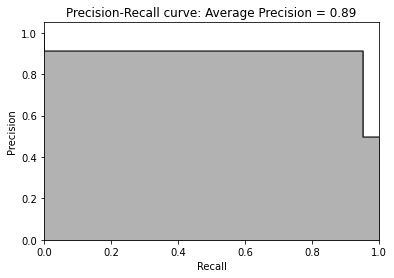

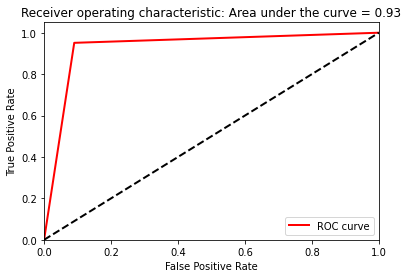

In [25]:
print('Starting predicting...')
pred_y = clf.predict(val_x)

# eval
print('auc:', roc_auc_score(val_y, pred_y))
print('confusion matrix:')
print(confusion_matrix(val_y, (pred_y > 0.5).astype(int)))
print('accuracy: ', accuracy_score(val_y, (pred_y > th)))
print('precision:', precision_score(val_y, (pred_y > 0.5)))
print('recall:', recall_score(val_y, (pred_y > 0.5)))
print('f1_score:', f1_score(val_y, (pred_y > 0.5)))

precision, recall, thresholds = precision_recall_curve(val_y,pred_y)
average_precision = average_precision_score(val_y,pred_y)

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

fpr, tpr, thresholds = roc_curve(val_y,pred_y)
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

Starting predicting...
auc: 0.7483130904183536
confusion matrix:
[[5908   20]
 [  36   36]]
accuracy:  0.9906666666666667
precision: 0.6428571428571429
recall: 0.5
f1_score: 0.5625000000000001


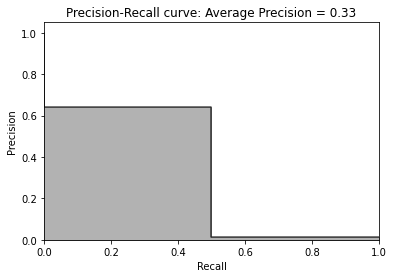

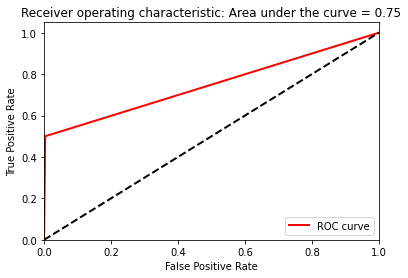

In [124]:
print('Starting predicting...')
pred_y = clf.predict(test_x.sample(6000, random_state=111))
test_y = test_y.sample(6000, random_state=111)
# eval
th = 0.97
print('auc:', roc_auc_score(test_y, pred_y))
print('confusion matrix:')
print(confusion_matrix(test_y, (pred_y > 0.5).astype(int)))
print('accuracy: ', accuracy_score(test_y, (pred_y > th)))
print('precision:', precision_score(test_y, (pred_y > th)))
print('recall:', recall_score(test_y, (pred_y > th)))
print('f1_score:', f1_score(test_y, (pred_y > th)))

precision, recall, thresholds = precision_recall_curve(test_y,pred_y)
average_precision = average_precision_score(test_y,pred_y)

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

fpr, tpr, thresholds = roc_curve(test_y,pred_y)
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

In [62]:
a= pd.DataFrame(np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]]),
                columns=['a', 'b', 'c'])
b= pd.DataFrame(np.array([[11, 12, 13], [14, 15, 16], [17, 18, 19]]),
                columns=['a', 'b', 'c'])

a = a.sample(2,random_state=222)
b = b.sample(2,random_state=222)

display(a)
b

,a,b,c
0,1,2,3
1,4,5,6


,a,b,c
0,11,12,13
1,14,15,16
